In [1]:
import batoid
import galsim
from donut_sims import wfsim

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# some initial setup
# we'll do r-band for this demo
bandpass = galsim.Bandpass("LSST_r.dat", wave_type="nm")
telescope = batoid.Optic.fromYaml("LSST_r.yaml")
pixel_scale = 10e-6 # microns / pixel

In [3]:
# setup observation parameters
# these are plausible numbers from Josh
observation = {
    "zenith": 30 * galsim.degrees,
    "raw_seeing": 0.7 * galsim.arcsec, # zenith 500nm seeing
    "wavelength": bandpass.effective_wavelength, # nm
    "exptime": 15.0, # seconds
    "temperature": 293.0, # Kelvin
    "pressure": 69.0, # kPa
    "H2O_pressure": 1.0, # kPa
}

In [4]:
# setup atmospheric parameters
atm_kwargs = {
    "screen_size": 819.2,
    "screen_scale": 0.1,
    "nproc": 6, # create sceens in parallel using this many CPUs
}

In [5]:
# We loaded the fiducial telescope - now let's perturb it out of alignment
# and misfigure the mirrors a little bit

# the big question is how much to perturb each degree-of-freedom
# for this demo, we will not dwell on this too much

seed = 0
rng = np.random.default_rng(seed)

# misalignment of M2 and camera first
M2_offset = rng.uniform(
    [-1e-4, -1e-4, -1e-4], # meters
    [+1e-4, +1e-4, +1e-4], # meters
)
M2_tilt = (
    batoid.RotX(np.deg2rad(rng.uniform(-1e-2, +1e-2) / 60)) @
    batoid.RotY(np.deg2rad(rng.uniform(-1e-2, +1e-2) / 60))
)

camera_offset = rng.uniform(
    [-1e-3, -1e-3, -1e-5], # meters
    [+1e-3, +1e-3, +1e-5], # meters
)
camera_tilt = (
    batoid.RotX(np.deg2rad(rng.uniform(-1e-2, +1e-2) / 60)) @
    batoid.RotY(np.deg2rad(rng.uniform(-1e-2, +1e-2) / 60))
)

perturbed = (
    telescope
    .withGloballyShiftedOptic("M2", M2_offset)
    .withLocallyRotatedOptic("M2", M2_tilt)
    .withGloballyShiftedOptic("LSSTCamera", camera_offset)
    .withLocallyRotatedOptic("LSSTCamera", camera_tilt)
)

# Now we'll perturb the main mirror
# we should use actual mirror modes, but for now, we'll just use Zernikes
M1M3_modes = rng.uniform(-1e-1, +1e-1, size=23) # waves
M1M3_modes *= bandpass.effective_wavelength * 1e-9 # meters

M1M3_surface_perturbation = batoid.Zernike(
    M1M3_modes,
    R_outer=telescope["M1"].obscuration.original.outer,
)

perturbed = telescope.withSurface(
    "M1",
    batoid.Sum([
        telescope["M1"].surface,
        M1M3_surface_perturbation,
    ])
)
perturbed = telescope.withSurface(
    "M3",
    batoid.Sum([
        telescope["M3"].surface,
        M1M3_surface_perturbation,
    ])
)

# M2 bends independently from M1M3
M2_modes = rng.uniform(-1e-1, +1e-1, size=23) # waves
M2_modes *= bandpass.effective_wavelength * 1e-9 # meters

M2_surface_perturbation = batoid.Zernike(
    M2_modes,
    R_outer=telescope["M2"].obscuration.original.outer,
)
perturbed = telescope.withSurface(
    "M2",
    batoid.Sum([
        telescope["M2"].surface,
        M2_surface_perturbation,
    ])
)

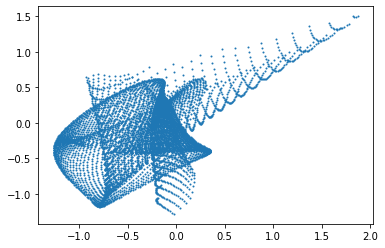

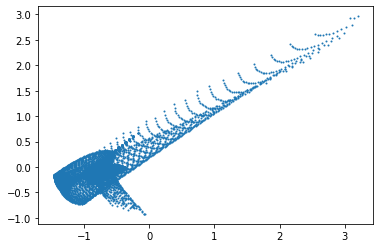

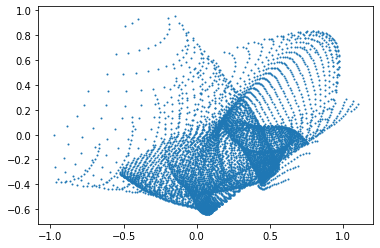

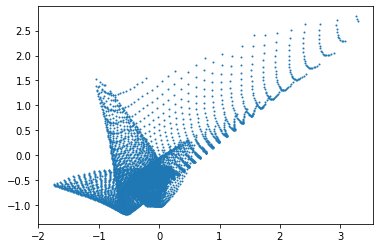

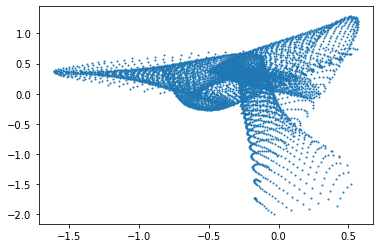

In [6]:
# We can take a quick look at how we've perturbed the optics by making 
# a spot diagram.  The batoid.spot tool returns points in meters, so
# we divide by pixel_scale to get pixels.  We also look in a few points
# around the field of view to get a global picture.

for thx, thy in [(0,0), (-1.5, 0), (1.5, 0), (0, -1.5), (0, 1.5)]:
    sx, sy = batoid.spot(
        perturbed, 
        np.deg2rad(thx), np.deg2rad(thy), 
        bandpass.effective_wavelength*1e-9, 
        nx=128
    )
    plt.figure()
    plt.scatter(sx/pixel_scale, sy/pixel_scale, s=1)
    plt.show()

In [31]:
# To make donuts, we need to be intra-focal or extra-focal.
# To simulate normal science operations mode, shift the detector:
intra = perturbed.withGloballyShiftedOptic(
    "Detector", [0, 0, -1.5e-3]
)
extra = perturbed.withGloballyShiftedOptic(
    "Detector", [0, 0, +1.5e-3]
)

In [32]:
intra_simulator = wfsim.SimpleSimulator(
    observation,
    atm_kwargs,
    intra,
    bandpass,
    shape=(256, 256),
    rng=rng
)

In [38]:
# Now we can choose some parameters for a star and start simulating
# First, choose a field angle.  At the moment, the simulator code only 
# works close to the boresight direction, so just use that.  I'll 
# extend that soon.
thx = np.deg2rad(0)
thy = np.deg2rad(0)

In [39]:
# We also want to simulate chromatically.  We could fetch an actual 
# stellar SED for this, but it's easier and probably always good enough
# to just use a black body with a reasonable temperature.
star_T = rng.uniform(4000, 10000)
sed = wfsim.BBSED(star_T)

In [40]:
# We also need a flux (which needs to be an integer):
flux = rng.integers(1_000_000, 2_000_000)

In [41]:
intra_simulator.add_star(thx, thy, sed, flux, rng)

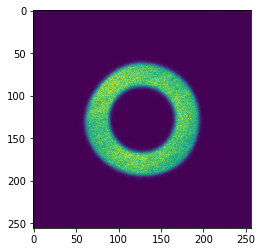

In [42]:
# We can look at our star now:
plt.figure()
plt.imshow(intra_simulator.image.array)
plt.show()

In [43]:
# Our image doesn't have any sky background noise in it yet.  
# Here we add some.
intra_simulator.add_background(1000.0, rng)

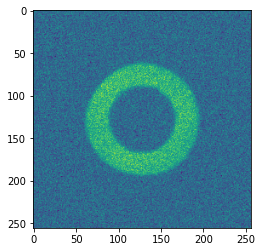

In [44]:
# Here's our final star
plt.figure()
plt.imshow(intra_simulator.image.array)
plt.show()

In [45]:
# Finally, what were the actual Zernike's for the perturbed telescope
# we generated?  Get that using batoid.zernike:
zs = batoid.zernike(
    perturbed, 
    thx, thy, 
    bandpass.effective_wavelength*1e-9  # batoid wants meters,
)
zs *= bandpass.effective_wavelength # waves -> nm
for j in range(4, 23):
    print(f"{j:>2d}  {zs[j]:6.1f} nm")

 4  -521.8 nm
 5  -120.6 nm
 6    73.0 nm
 7    23.2 nm
 8    77.7 nm
 9    30.8 nm
10    -2.7 nm
11   230.4 nm
12   -70.9 nm
13    50.1 nm
14   -22.1 nm
15    74.4 nm
16   -56.0 nm
17   -48.0 nm
18    43.7 nm
19   -63.2 nm
20    73.3 nm
21    27.2 nm
22    -8.6 nm


Text(0, 0.5, 'Wave')

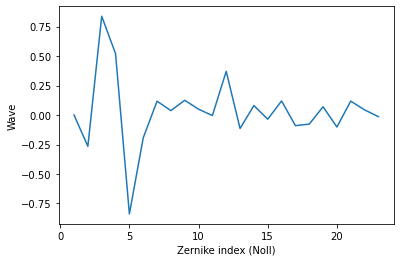

In [55]:
plt.plot(np.arange(1, 24), zs / bandpass.effective_wavelength)
plt.xlabel("Zernike index (Noll)")
plt.ylabel("Wave")